In [1]:
# Ho Chi Minh city University of Science (HCMUS)
# Author: Phan Minh Phuc
# Student ID: 20127063
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as img
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.utils import shuffle
from time import time

In [53]:
def generate_centroid(img_1d, k_clusters, init_centroids):
    if init_centroids == 'in_pixels':
        return img_1d[np.random.randint(img_1d.shape[0], size = k_clusters), :]
        # return img_1d[np.random.choice(img_1d.shape[0], k_clusters, replace= False)]
    if init_centroids == 'random':
        return np.random.randint(256, size = (k_clusters, 3))

In [54]:
def classify_pixel(img_1d, centroid):
    # distance between each pixel and the 1st controid
    distance = np.linalg.norm(img_1d - centroid[0], axis = 1)
    # convert the array to shape (img_1d.shape[0], 1)
    distance = distance.reshape((img_1d.shape[0], 1))
    
    # distance between each pixel and the rest controids
    for i in range (1, centroid.shape[0]): 
        temp = np.linalg.norm(img_1d - centroid[i], axis = 1)
        temp = temp.reshape((img_1d.shape[0], 1))
        # adding these distances to the initial distance array
        distance = np.concatenate((distance,temp),axis=1)
        
    # return index of centroid nearest to each pixel
    #  return distance    
    return np.argmin(distance,axis = 1)

In [55]:
def optimize_centroid(img_1d, k_cluster, centroid):
    label = classify_pixel(img_1d, centroid)
    is_changed = False
    for i in range (k_cluster):
        # choose all pixels belong to centroid[k]
        cluster = img_1d[label == i, :]
        # if no pixel belong to this centroid
        # => go on to the next centroid        
        if len(cluster) == 0:
            continue
        # generate a new centroid from mean value of last chosen pixels 
        new_centroid = np.mean(cluster, axis = 0)
        # if new centroid and centroid[k] is not convergent
        # => set centroid[k] with the new centroid's value
        if (not np.allclose(centroid[i], new_centroid, atol = 1, equal_nan = True)):
            centroid[i] = new_centroid
            is_changed = True
        
    return is_changed, centroid, label 

In [56]:
def compress_pixel(img_1d, k_clusters, label, centroids):
    for i in range(k_clusters):
        img_1d[label == i, :] = centroids[i]
    return img_1d

In [57]:
def kmeans(img_1d, k_clusters, max_iter, init_centroids):    
    centroid = generate_centroid(img_1d, k_clusters, init_centroids)
    label = []
    while max_iter > 0: 
        stop_condition, centroid, label = optimize_centroid(img_1d, k_clusters, centroid)
        if stop_condition == False:
            break;
        max_iter -= 1;
        
    # print(label.shape)    
    return centroid, label

In [58]:
def main():
    filename = input("Enter image's name: ")
    print("Filename: " + filename)   
    output_format = input("Enter image's output format ('png' or 'pdf'): ")
    print("Image's output format: " + output_format)
    while output_format != "png" and output_format != "pdf":
        output_format = input("Enter image's output format ('png' or 'pdf'): ")
        print("Image's output format: " + output_format)
    
    img_1d = img.open(filename)    
    # Convert the input to a matrix.
    img_1d = np.asarray(img_1d)
    
    # img_1d.shape[0]: number of rows 
    # img_1d.shape[1]: number of columns
    # img_1d.shape[2]: number of channels
    row = img_1d.shape[0]
    column = img_1d.shape[1]
    # Reshape initial matrix to 1d array
    # img_1d.reshape(-1, 3) == img_1d.reshape(img_1d.shape[0] * img_1d.shape[1], img_1d.shape[])
    img_1d = img_1d.reshape(-1, 3)
    
    k_clusters = 7
    max_iter = 3000
    centroid, label = kmeans(img_1d, k_clusters, max_iter, init_centroids = 'in_pixels')
    
    compressed_img = compress_pixel(img_1d, k_clusters, label, centroid)
    compressed_img = compressed_img.reshape(row, column, 3)
    print(f"Number of clusters: {k_clusters}")
    print(f"Centroids: \n {centroid}")
    plt.clf()
    print(f"Compressed image ({k_clusters} colors, Project 1: Color Compression)")
    figure = plt.figure()
    figure.set_size_inches(column / 96, row / 96)
    plt.axis("off")
    plt.imshow(compressed_img)
    plt.savefig(f"compressed_img{k_clusters}." + output_format, dpi = 300)

Enter image's name: 2.jpg
Filename: 2.jpg
Enter image's output format ('png' or 'pdf'): pdf
Image's output format: pdf
Number of clusters: 7
Centroids: 
 [[  6   6 103]
 [  1   2  89]
 [ 29  30 112]
 [  8   9 110]
 [ 19  20 131]
 [ 18  17 102]
 [ 12  12 115]]
Compressed image (7 colors, Project 1: Color Compression)


<Figure size 432x288 with 0 Axes>

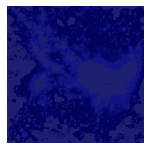

In [59]:
main()

Enter image's name: 1.jpg
Filename: 1.jpg
Fitting model on a small sub-sample of the data
done in 0.109s.
Predicting color indices on the full image (k-means)
done in 0.139s.
Centroids: 
 [[114.87359551  90.10674157 133.38483146]
 [ 29.00877193  24.1754386   64.66666667]
 [196.92384106 154.59933775 168.01655629]]


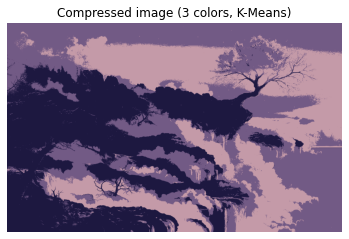

In [23]:
# compare results with KMeans in scikit-learn library
n_colors = 3

# Load the Summer Palace photo
pic_name = input("Enter image's name: ")
print("Filename: " + pic_name)

image = img.open(pic_name)
# Convert to floats instead of the default 8 bits integer coding. Dividing by
# 255 is important so that plt.imshow behaves works well on float data (need to
# be in the range [0-1])
image = np.array(image, dtype=np.float64) / 255

# Load Image and transform to a 2D numpy array.
w, h, d = original_shape = tuple(image.shape)
assert d == 3
image_array = np.reshape(image, (w * h, d))

print("Fitting model on a small sub-sample of the data")
t0 = time()
image_array_sample = shuffle(image_array, random_state=0, n_samples=1_000)
km = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
print(f"done in {time() - t0:0.3f}s.")

# Get labels for all points
print("Predicting color indices on the full image (k-means)")
t0 = time()
labels = km.predict(image_array)
print(f"done in {time() - t0:0.3f}s.")

def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    return codebook[labels].reshape(w, h, -1)

print(f'Centroids: \n {km.cluster_centers_ * 255}')
plt.figure(2)
plt.clf()
plt.axis("off")
plt.title(f"Compressed image ({n_colors} colors, K-Means)")
plt.imshow(recreate_image(km.cluster_centers_, labels, w, h))